In [1]:
MODEL = "vit_b_16"  # enter model name
N_EPOCHS = 50  # enter number of epochs
EARLY_STOPPING_PATIENCE = (
    8  # Stop if validation loss doesn't improve for this many epochs
)
LEARNING_RATE = 1e-4  # enter learning rate
COLAB_DATA_MODE = "mount"  # Can be 'mount' (symlink) or 'copy'. Only used if on colab
AUGMENTATION = True
CONTINUE_TRAINING = True

In [2]:
### Setup if using colab ###
import os
import sys
import subprocess
import shutil  # Added import for shutil


def in_colab() -> bool:
    try:
        import google.colab  # type: ignore

        return True
    except Exception:
        return False


if in_colab():
    from google.colab import drive  # type: ignore

    print("Detected Colab. Mounting Drive...")
    drive.mount("/content/drive", force_remount=False)

    GITHUB_REPO = "https://github.com/chihuangliu/microrobot-dl.git"
    REPO_PATH = "/content/microrobot-dl"
    DRIVE_DATA_PATH = "/content/drive/MyDrive/microrobot-dl-data/data"  # where you uploaded your data on Drive

    # Clone repo if missing
    if not os.path.exists(REPO_PATH):
        print("Cloning repository...")
        subprocess.check_call(["git", "clone", GITHUB_REPO, REPO_PATH])
    else:
        print("Repository already cloned:", REPO_PATH)

    # Install package (editable) from repo root
    os.chdir(REPO_PATH)
    print("Installing package from", REPO_PATH)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "uv"])
    subprocess.check_call([sys.executable, "-m", "uv", "pip", "install", "-e", "."])

    # Handle data based on COLAB_DATA_MODE
    repo_data_path = os.path.join(REPO_PATH, "data")

    # Clean up existing data path entry point first
    if os.path.exists(repo_data_path):
        if os.path.islink(repo_data_path):
            print(f"Removing existing symlink: {repo_data_path}")
            os.unlink(repo_data_path)
        elif os.path.isdir(repo_data_path):
            print(f"Removing existing directory: {repo_data_path}")
            shutil.rmtree(repo_data_path)
        else:
            print(f"Removing existing file/socket: {repo_data_path}")
            os.remove(repo_data_path)

    if not os.path.exists(DRIVE_DATA_PATH):
        print("Drive data path not found:", DRIVE_DATA_PATH)
        print(
            "Upload your data to Drive and set DRIVE_DATA_PATH accordingly. No data will be linked/copied."
        )
    else:
        if COLAB_DATA_MODE == "copy":
            print("Copying Drive data from:", DRIVE_DATA_PATH, "to", repo_data_path)
            shutil.copytree(DRIVE_DATA_PATH, repo_data_path)
            print("Data copied successfully.")
        elif COLAB_DATA_MODE == "mount":
            print(
                "Creating symlink from Drive data:",
                DRIVE_DATA_PATH,
                "to",
                repo_data_path,
            )
            os.symlink(DRIVE_DATA_PATH, repo_data_path)
            print("Data symlinked successfully.")
        else:
            print(
                f"Warning: Unknown COLAB_DATA_MODE '{COLAB_DATA_MODE}'. No data will be linked/copied."
            )

    # Change into notebooks/ so relative paths in the notebook continue to work
    notebooks_dir = os.path.join(REPO_PATH, "notebooks")
    if os.path.isdir(notebooks_dir):
        os.chdir(notebooks_dir)
        print("Changed working dir to notebooks:", os.getcwd())
    else:
        print("No notebooks/ dir found; current working dir:", os.getcwd())

    if REPO_PATH not in sys.path:
        sys.path.insert(0, REPO_PATH)
else:
    print("Not running on colab.")

Not running on colab.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from microrobot_dl.transform import AddGaussianNoise, TranslateTransform, ZoomTransform
from tqdm import tqdm
import os
import json


torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [4]:
# Load Dataset
dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset", mode="pose", multi_label=False, transform=None
)

num_classes = len(dataset.idx_to_label)
print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {dataset.idx_to_label}")

Total samples: 2002
Number of classes: 40
Classes: ['P0_R0', 'P10_R0', 'P15_R0', 'P15_R15', 'P15_R30', 'P15_R45', 'P15_R5', 'P25_R0', 'P30_R0', 'P30_R10', 'P30_R15', 'P30_R30', 'P30_R45', 'P30_R5', 'P30_R60', 'P35_R0', 'P40_R0', 'P45_R0', 'P45_R10', 'P45_R15', 'P45_R30', 'P45_R45', 'P45_R5', 'P45_R60', 'P50_R0', 'P55_R0', 'P5_R0', 'P60_R0', 'P60_R10', 'P60_R15', 'P60_R30', 'P60_R45', 'P60_R5', 'P60_R60', 'P65_R0', 'P70_R0', 'P75_R0', 'P80_R0', 'P85_R0', 'P90_R0']


In [5]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

if AUGMENTATION:
    transform_train = transforms.Compose(
        [
            transforms.Resize((240, 240)),
            TranslateTransform(),
            ZoomTransform(size=(224, 224), scale=(0.8, 1.0)),
            transforms.ToTensor(),
            AddGaussianNoise(0.0, 0.02),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ]
    )
else:
    transform_train = transform_test


t_train = transform_train if AUGMENTATION else transform_test
t_test = transform_test

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
    transform_train=t_train,
    transform_test=t_test,
)

In [6]:
# Setup Model
model = get_model(MODEL, num_classes=num_classes, in_channels=1)

if model is None:
    raise ValueError(f"Model {MODEL} not supported.")

model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
if AUGMENTATION:
    suffix = "_augmented"
else:
    suffix = ""

MODEL_NAME = f"{MODEL}_pose_model_single_label{suffix}"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float("inf")
epochs_no_improve = 0  # Counter for early stopping


if CONTINUE_TRAINING and os.path.exists(MODEL_PATH):
    print(f"Loading checkpoint from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    if "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_loss = checkpoint.get("val_loss", float("inf"))
    start_epoch = checkpoint.get("epoch", 0)

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(
            f"Early stopping triggered. No improvement for {EARLY_STOPPING_PATIENCE} epochs."
        )
        break

Loading checkpoint from ../model/vit_b_16_pose_model_single_label_augmented.pth...
Resuming training from epoch 50...
Resuming training from epoch 50...


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]


Epoch 1/50 - Train Loss: 0.7659 Acc: 0.7136 | Val Loss: 0.7130 Acc: 0.7375


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]



Epoch 2/50 - Train Loss: 0.7833 Acc: 0.7157 | Val Loss: 0.7260 Acc: 0.7250


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]



Epoch 3/50 - Train Loss: 0.7170 Acc: 0.7497 | Val Loss: 0.7175 Acc: 0.7500


100%|██████████| 46/46 [00:47<00:00,  1.03s/it]



Saved best model to ../model/vit_b_16_pose_model_single_label_augmented.pth (Val Loss: 0.5543)
Epoch 4/50 - Train Loss: 0.7379 Acc: 0.7393 | Val Loss: 0.5543 Acc: 0.7937


100%|██████████| 46/46 [00:47<00:00,  1.03s/it]



Epoch 5/50 - Train Loss: 0.7733 Acc: 0.7337 | Val Loss: 0.7634 Acc: 0.7375


100%|██████████| 46/46 [00:47<00:00,  1.03s/it]



Epoch 6/50 - Train Loss: 0.6919 Acc: 0.7483 | Val Loss: 0.6414 Acc: 0.7937


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Epoch 7/50 - Train Loss: 0.7477 Acc: 0.7295 | Val Loss: 0.6205 Acc: 0.7750


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]



Epoch 8/50 - Train Loss: 0.6117 Acc: 0.7843 | Val Loss: 0.5802 Acc: 0.7875


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Epoch 9/50 - Train Loss: 0.6251 Acc: 0.7677 | Val Loss: 0.7489 Acc: 0.7188


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]



Saved best model to ../model/vit_b_16_pose_model_single_label_augmented.pth (Val Loss: 0.5128)
Epoch 10/50 - Train Loss: 0.6713 Acc: 0.7684 | Val Loss: 0.5128 Acc: 0.8562


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Saved best model to ../model/vit_b_16_pose_model_single_label_augmented.pth (Val Loss: 0.3742)
Epoch 11/50 - Train Loss: 0.5903 Acc: 0.7899 | Val Loss: 0.3742 Acc: 0.8750


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Epoch 12/50 - Train Loss: 0.5781 Acc: 0.7947 | Val Loss: 0.4994 Acc: 0.8187


100%|██████████| 46/46 [00:49<00:00,  1.07s/it]



Epoch 13/50 - Train Loss: 0.5893 Acc: 0.7878 | Val Loss: 0.4857 Acc: 0.8250


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Epoch 14/50 - Train Loss: 0.6210 Acc: 0.7732 | Val Loss: 0.5958 Acc: 0.8000


100%|██████████| 46/46 [00:47<00:00,  1.03s/it]



Epoch 15/50 - Train Loss: 0.6031 Acc: 0.7857 | Val Loss: 0.4924 Acc: 0.8063


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Epoch 16/50 - Train Loss: 0.5301 Acc: 0.8121 | Val Loss: 0.4866 Acc: 0.8000


100%|██████████| 46/46 [00:47<00:00,  1.04s/it]



Epoch 17/50 - Train Loss: 0.5491 Acc: 0.7975 | Val Loss: 0.4477 Acc: 0.8187


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]



Saved best model to ../model/vit_b_16_pose_model_single_label_augmented.pth (Val Loss: 0.3701)
Epoch 18/50 - Train Loss: 0.5378 Acc: 0.8024 | Val Loss: 0.3701 Acc: 0.8812


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 19/50 - Train Loss: 0.4615 Acc: 0.8301 | Val Loss: 0.5064 Acc: 0.8063


100%|██████████| 46/46 [00:46<00:00,  1.01s/it]



Epoch 20/50 - Train Loss: 0.7111 Acc: 0.7469 | Val Loss: 0.5735 Acc: 0.7562


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 21/50 - Train Loss: 0.5352 Acc: 0.8037 | Val Loss: 0.4795 Acc: 0.8125


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 22/50 - Train Loss: 0.5649 Acc: 0.7982 | Val Loss: 0.5128 Acc: 0.8187


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 23/50 - Train Loss: 0.4834 Acc: 0.8211 | Val Loss: 0.4064 Acc: 0.8313


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 24/50 - Train Loss: 0.5572 Acc: 0.7975 | Val Loss: 0.6049 Acc: 0.8063


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 25/50 - Train Loss: 0.5006 Acc: 0.8239 | Val Loss: 0.4546 Acc: 0.8125


100%|██████████| 46/46 [00:46<00:00,  1.02s/it]



Epoch 26/50 - Train Loss: 0.4388 Acc: 0.8384 | Val Loss: 0.4488 Acc: 0.8313
Early stopping triggered. No improvement for 8 epochs.


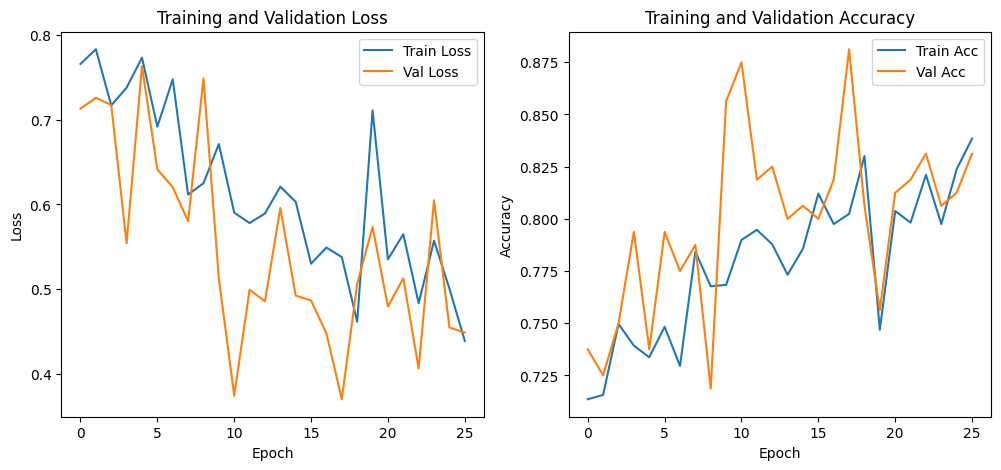

In [8]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

In [11]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_acc_loaded = checkpoint.get("val_acc")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_acc={val_acc_loaded}, val_loss={val_loss_loaded})"
)

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Loaded checkpoint from ../model/vit_b_16_pose_model_single_label_augmented.pth (epoch=18, val_acc=0.88125, val_loss=0.37005159854888914)
Test Set Accuracy: 0.8150
Test Set Accuracy: 0.8150


In [ ]:
results = {
    "model_name": MODEL_NAME,
    "accuracy": test_accuracy,
    "metadata": {
        "N_EPOCHS": N_EPOCHS + start_epoch if CONTINUE_TRAINING else N_EPOCHS,
        "EARLY_STOPPING_PATIENCE": EARLY_STOPPING_PATIENCE,
        "augmentation": AUGMENTATION,
        "learning_rate": LEARNING_RATE,
    },
}

out_dir = ".eval"
out_path = os.path.join(out_dir, f"{MODEL_NAME}.json")

if os.path.exists(out_path):
    try:
        with open(out_path, "r") as f:
            existing = json.load(f)
    except Exception:
        existing = None

    if isinstance(existing, list):
        existing.append(results)
        data_to_write = existing
    elif isinstance(existing, dict):
        data_to_write = [existing, results]
    else:
        data_to_write = [results]
else:
    data_to_write = [results]

with open(out_path, "w") as f:
    json.dump(data_to_write, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to .eval/vit_b_16_pose_model_single_label_augmented.json
